In [1]:
# Install necessary packages
!pip install --upgrade scikit-learn imbalanced-learn keras keras-tuner scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
# Importing all necessary libraries

import warnings
import numpy as np

# Reading the dataset
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Importing packages for building and tuning the model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

# Undersampling
from imblearn.under_sampling import NearMiss

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# For Undersampling & Oversampling
from imblearn.combine import SMOTETomek

# For splitting the data into train and test sets
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from keras_tuner.tuners import RandomSearch

# Check acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
# Optional: ignore warnings for cleaner output
warnings.filterwarnings('ignore')


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load the dataset
dataset_path = "/content/gdrive/MyDrive/ColabData/loan.csv"

# Low memory to control the memory usage while reading the file.
# False to aviod a 'DtypeWarning' warning for columns with mixed datatypes.
df = pd.read_csv(dataset_path, low_memory=False)
print("Shape of the dataset:", df.shape)


Shape of the dataset: (887379, 74)


In [6]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Minimize the Features given 74 features in the Dataset that are not required**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

# Data Cleaning

Find percentage of null values in each column in order to drop certain columns that don't meet a percentage threshold

In [8]:
# Calculate the percentage of missing values in df
percentage_missing = (df.isnull().sum() / len(df) * 100).round(2)
print(percentage_missing)

id                   0.00
member_id            0.00
loan_amnt            0.00
funded_amnt          0.00
funded_amnt_inv      0.00
                    ...  
all_util            97.59
total_rev_hi_lim     7.92
inq_fi              97.59
total_cu_tl         97.59
inq_last_12m        97.59
Length: 74, dtype: float64


In [9]:
# overview of the dataset, including the percentage of missing values
print(df.describe(include='all'))

                  id     member_id      loan_amnt    funded_amnt  \
count   8.873790e+05  8.873790e+05  887379.000000  887379.000000   
unique           NaN           NaN            NaN            NaN   
top              NaN           NaN            NaN            NaN   
freq             NaN           NaN            NaN            NaN   
mean    3.246513e+07  3.500182e+07   14755.264605   14741.877625   
std     2.282734e+07  2.411335e+07    8435.455601    8429.897657   
min     5.473400e+04  7.047300e+04     500.000000     500.000000   
25%     9.206643e+06  1.087713e+07    8000.000000    8000.000000   
50%     3.443327e+07  3.709528e+07   13000.000000   13000.000000   
75%     5.490814e+07  5.847135e+07   20000.000000   20000.000000   
max     6.861706e+07  7.354484e+07   35000.000000   35000.000000   

        funded_amnt_inv        term       int_rate    installment   grade  \
count     887379.000000      887379  887379.000000  887379.000000  887379   
unique              NaN      

In [10]:
# Filter the DataFrame based on the percentage of missing values
features_to_keep = df.columns[((df.isnull().sum()/len(df))*100 < 20)].tolist()
df_filtered = df[features_to_keep]
print("Total features before:", len(df.columns))
print("Total features now:", len(df_filtered.columns))

Total features before: 74
Total features now: 52


In [11]:
# Keeping only those features with less than 20% of missing values
features_to_keep = df.columns[((df.isnull().sum()/len(df))*100 < 20)].to_list()
print("Total features before:", len(df.columns))
print("Total features now:", len(features_to_keep))

Total features before: 74
Total features now: 52


In [12]:
df1=df[features_to_keep]
df1.shape

(887379, 52)

In [13]:
# List of 21 selected features for further analysis
selected_features = [
    'loan_amnt',
    'term',
    'int_rate',
    'installment',
    'grade',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'verification_status',
    'purpose',
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'last_pymnt_amnt',
    'loan_status'
]

print(len(selected_features))

21


# Loan Dataset Columns

# Loan Information
- loan_amnt: the amount of the loan
- term: the term of the loan (36 or 60 months)
- int_rate: the interest rate of the loan
- installment: the monthly payment of the loan

# Borrower Information
- grade: the grade assigned by LendingClub based on the creditworthiness of the borrower
- sub_grade: a more detailed grade based on the borrower's creditworthiness
- emp_length: the length of employment of the borrower
- home_ownership: the type of home ownership of the borrower
- annual_inc: the annual income of the borrower
- verification_status: whether the income was verified by LendingClub

# Loan Details
- purpose: the purpose of the loan
- dti: the debt-to-income ratio of the borrower
- delinq_2yrs: the number of delinquencies in the past 2 years
- inq_last_6mths: the number of inquiries in the last 6 months
- open_acc: the number of open credit lines in the borrower's credit file
- pub_rec: the number of derogatory public records
- revol_bal: the total credit revolving balance
- revol_util: the amount of credit the borrower is using relative to their total credit limit
- total_acc: the total number of credit lines in the borrower's credit file
- last_pymnt_amnt: the last payment amount received

In [14]:
df=df1[selected_features]
print("Shape of the dataset:",df.shape)
df.head()

Shape of the dataset: (887379, 21)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,loan_status
0,5000.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,...,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,171.62,Fully Paid
1,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,...,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,119.66,Charged Off
2,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,...,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,649.91,Fully Paid
3,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,...,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,357.48,Fully Paid
4,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,...,17.94,0.0,0.0,15.0,0.0,27783.0,53.9,38.0,67.79,Current


In [15]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt
count,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000
mean,14755.264605,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,11.548469,0.195307,1.692079e+04,55.067693,25.268026,2164.145585
std,8435.455601,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,5.317313,0.582091,2.242679e+04,23.834344,11.840561,4794.783233
min,500.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000
25%,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,8.000000,0.000000,6.443000e+03,37.700000,17.000000,280.170000
50%,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,11.000000,0.000000,1.187500e+04,56.000000,24.000000,462.780000
75%,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,1.000000,14.000000,0.000000,2.082900e+04,73.600000,32.000000,831.245000
max,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,33.000000,90.000000,86.000000,2.904836e+06,892.300000,169.000000,36475.590000


Since 'loan_status' is the target variable, it is important to explore this feature.

In [16]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

 Model to predict whether the loan was full paid off or charged. Select only those samples that have loan status either full paid off or charged.

In [17]:
target_loan= ["Fully Paid","Charged Off"]
df=df[df["loan_status"].isin(target_loan)]
print(df.shape)

(252971, 21)


# Setting the 'Default' label for binary classification
The goal is to predict whether a loan is likely to default or not.
For this, we will assign 1 to 'Default' and similar statuses, and 0 to the rest.

## 'Loan_status' column's labels and their meanings:
- Fully Paid: The loan has been fully paid off by the borrower.
- Charged Off: The loan has not been fully repaid and Lending Club has charged off the remaining balance as a loss.
- Current: The loan is currently being repaid on schedule.
- Default: The borrower has failed to make payments on the loan and the loan is in default.
- Late (31-120 days): The borrower has missed payments and is between 31 and 120 days late on their payment schedule.
- In Grace Period: The borrower is in a grace period and has missed a payment.
- Late (16-30 days): The borrower has missed a payment and is between 16 and 30 days late on their payment schedule.
- Does not meet the credit policy. Status:Fully Paid: The loan has been fully paid off, but did not meet Lending Club's credit underwriting policy.
- Does not meet the credit policy. Status:Charged Off: The loan did not meet Lending Club's credit underwriting policy and has been charged off as a loss.
- Issued: The loan has been issued but has not yet been funded by investors.

 We will categorize 'Charged Off', 'Default', 'Late (31-120 days)', and 'Late (16-30 days)' as 1 (Defaulter), and the rest as 0 (Not a defaulter).


##Exploratory Data Analysis

In [18]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_length             9897
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
dti                       0
delinq_2yrs               0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              199
total_acc                 0
last_pymnt_amnt           0
loan_status               0
dtype: int64

In [19]:
# Handle missing values
# 'emp_length' is filled with the most frequent value (mode)
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mode()[0])

# 'revol_util' is filled with the median value
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())

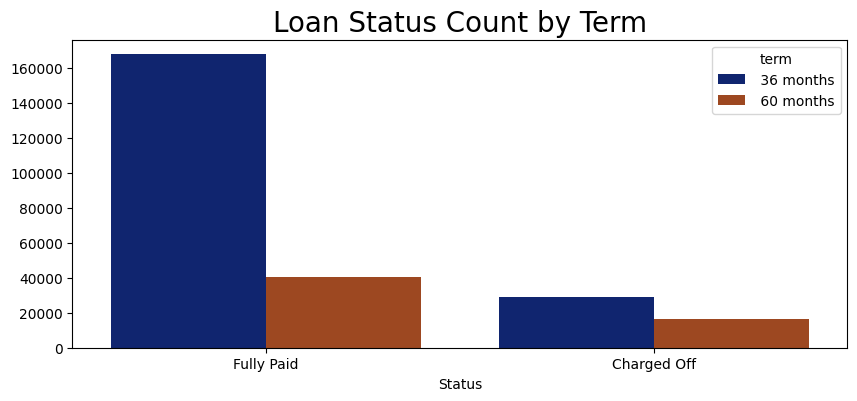

In [20]:
# Visualization
# 1. Countplot of Loan status  loan term
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="loan_status", hue="term", palette='dark')
plt.xlabel('Status')
plt.ylabel('')
plt.title('Loan Status Count by Term', size=20)
plt.show()

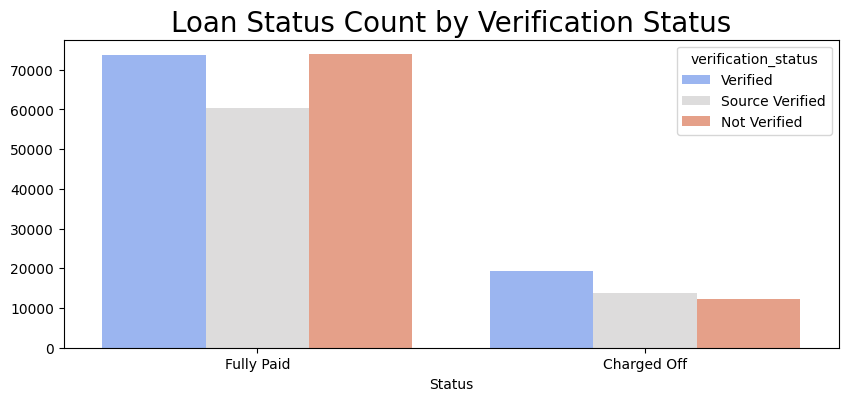

In [21]:
# 2. Countplot of loan status by verification status
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="loan_status", hue="verification_status", palette='coolwarm')
plt.xlabel('Status')
plt.ylabel('')
plt.title('Loan Status Count by Verification Status', size=20)
plt.show()

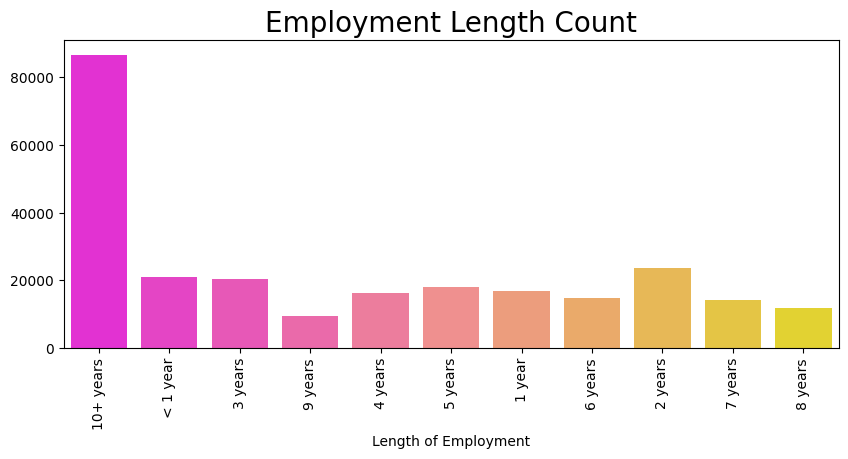

In [22]:
# 3. Countplot of employment length
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="emp_length", palette='spring')
plt.xlabel('Length of Employment')
plt.ylabel('')
plt.title('Employment Length Count', size=20)
plt.xticks(rotation='vertical')
plt.show()

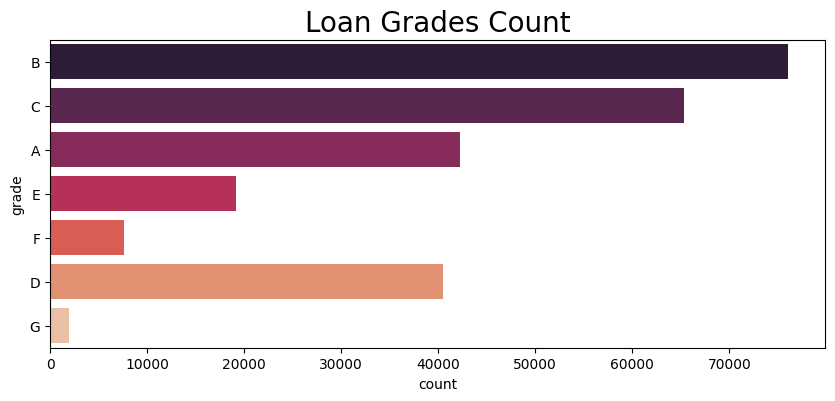

In [23]:
# 4. Countplot of loan grades
plt.figure(figsize=(10, 4))
sns.countplot(data=df, y="grade", palette='rocket')
plt.title('Loan Grades Count', size=20)
plt.show()

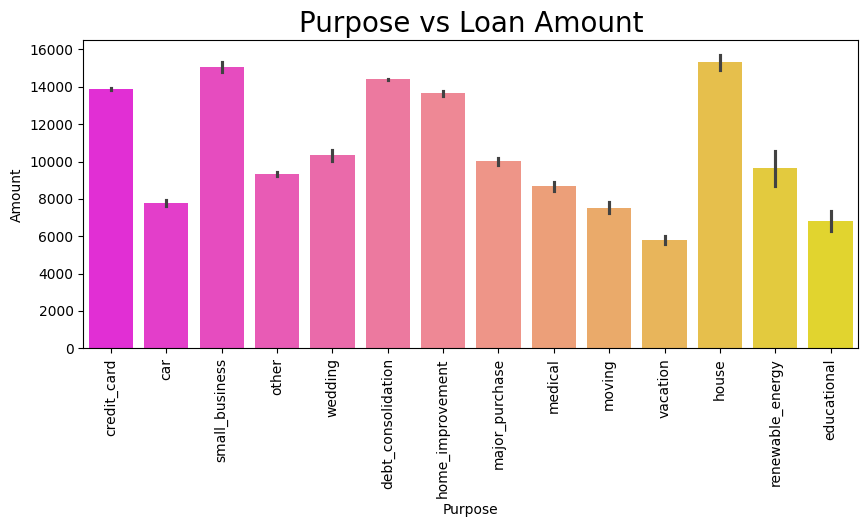

In [24]:
# 5. Barplot of loan amount by purpose
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="purpose", y='loan_amnt', palette='spring')
plt.xlabel('Purpose')
plt.ylabel('Amount')
plt.title('Purpose vs Loan Amount', size=20)
plt.xticks(rotation='vertical')
plt.show()

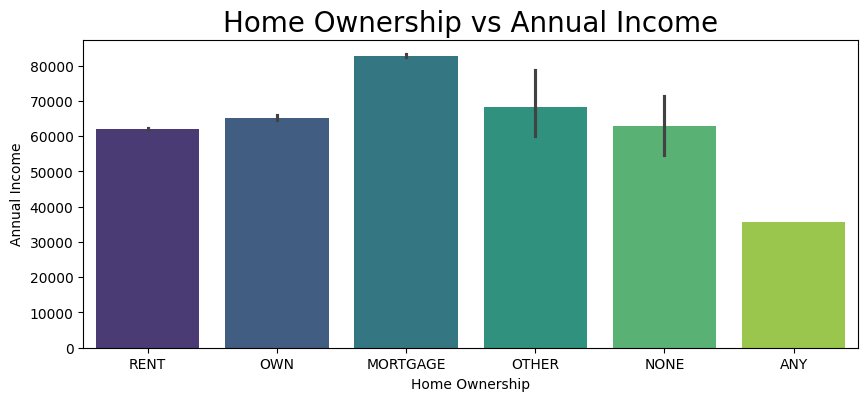

In [25]:
# 6. Barplot of annual income by home ownership
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="home_ownership", y='annual_inc', palette='viridis')
plt.xlabel('Home Ownership')
plt.ylabel('Annual Income')
plt.title('Home Ownership vs Annual Income', size=20)
plt.show()

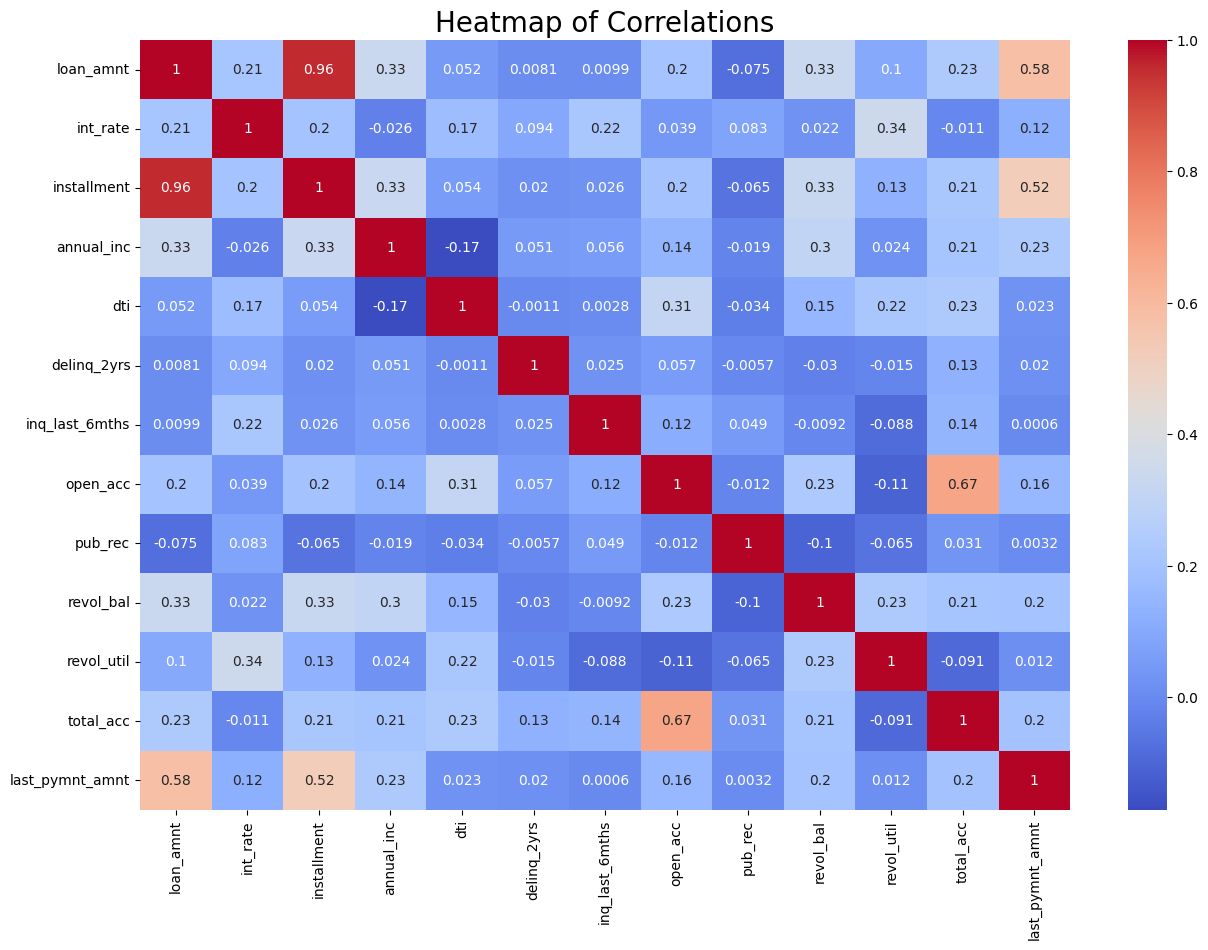

In [26]:
# Plotting a heatmap
# Select only numeric columns for the heatmap
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]

# Plotting a heatmap of correlations
plt.figure(figsize=(15, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlations', size=20)
plt.show()

In [27]:
# Dividing our features into categorical and numerical
categorical = [feature for feature in df.columns if df[feature].dtype == 'object']
numerical = [feature for feature in df.columns if feature not in categorical]
print("Categorical columns:", categorical)
print("Numerical columns:", numerical)

Categorical columns: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'loan_status']
Numerical columns: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt']


In [28]:
# Function to create histograms for numerical variables
def histplot_visual(data, columns, rows=3, cols=5):
    """
    Plots histograms for numerical columns.

    Parameters:
    data (DataFrame): The dataset containing the columns.
    columns (list): List of numerical columns to plot.
    rows (int): Number of rows in the subplot grid.
    cols (int): Number of columns in the subplot grid.
    """
    total_plots = len(columns)
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3))
    fig.suptitle('Histplot for each variable', y=1.05, size=20)
    ax = ax.flatten()

    for i in range(total_plots):
        if i < len(columns):
            sns.histplot(data=data[columns[i]], ax=ax[i], kde=True)
            ax[i].set_title(columns[i])
        else:
            fig.delaxes(ax[i])  # Remove empty subplots

    plt.tight_layout()
    plt.show()


In [29]:
# Function to create boxplots for numerical variables
def boxplots_visual(data, columns, rows=3, cols=5):
    """
    Plots boxplots for numerical columns.

    Parameters:
    data (DataFrame): The dataset containing the columns.
    columns (list): List of numerical columns to plot.
    rows (int): Number of rows in the subplot grid.
    cols (int): Number of columns in the subplot grid.
    """
    total_plots = len(columns)
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3))
    fig.suptitle('Boxplot for each variable', y=1.05, size=20)
    ax = ax.flatten()

    for i in range(total_plots):
        if i < len(columns):
            sns.boxplot(data=data[columns[i]], ax=ax[i], orient='h')
            skewness = round(data[columns[i]].skew(axis=0, skipna=True), 2)
            ax[i].set_title(f'{columns[i]}, skewness: {skewness}', fontsize=10)
            ax[i].set_xlim([data[columns[i]].min(), data[columns[i]].max()])
        else:
            fig.delaxes(ax[i])  # Remove empty subplots

    plt.tight_layout()
    plt.show()

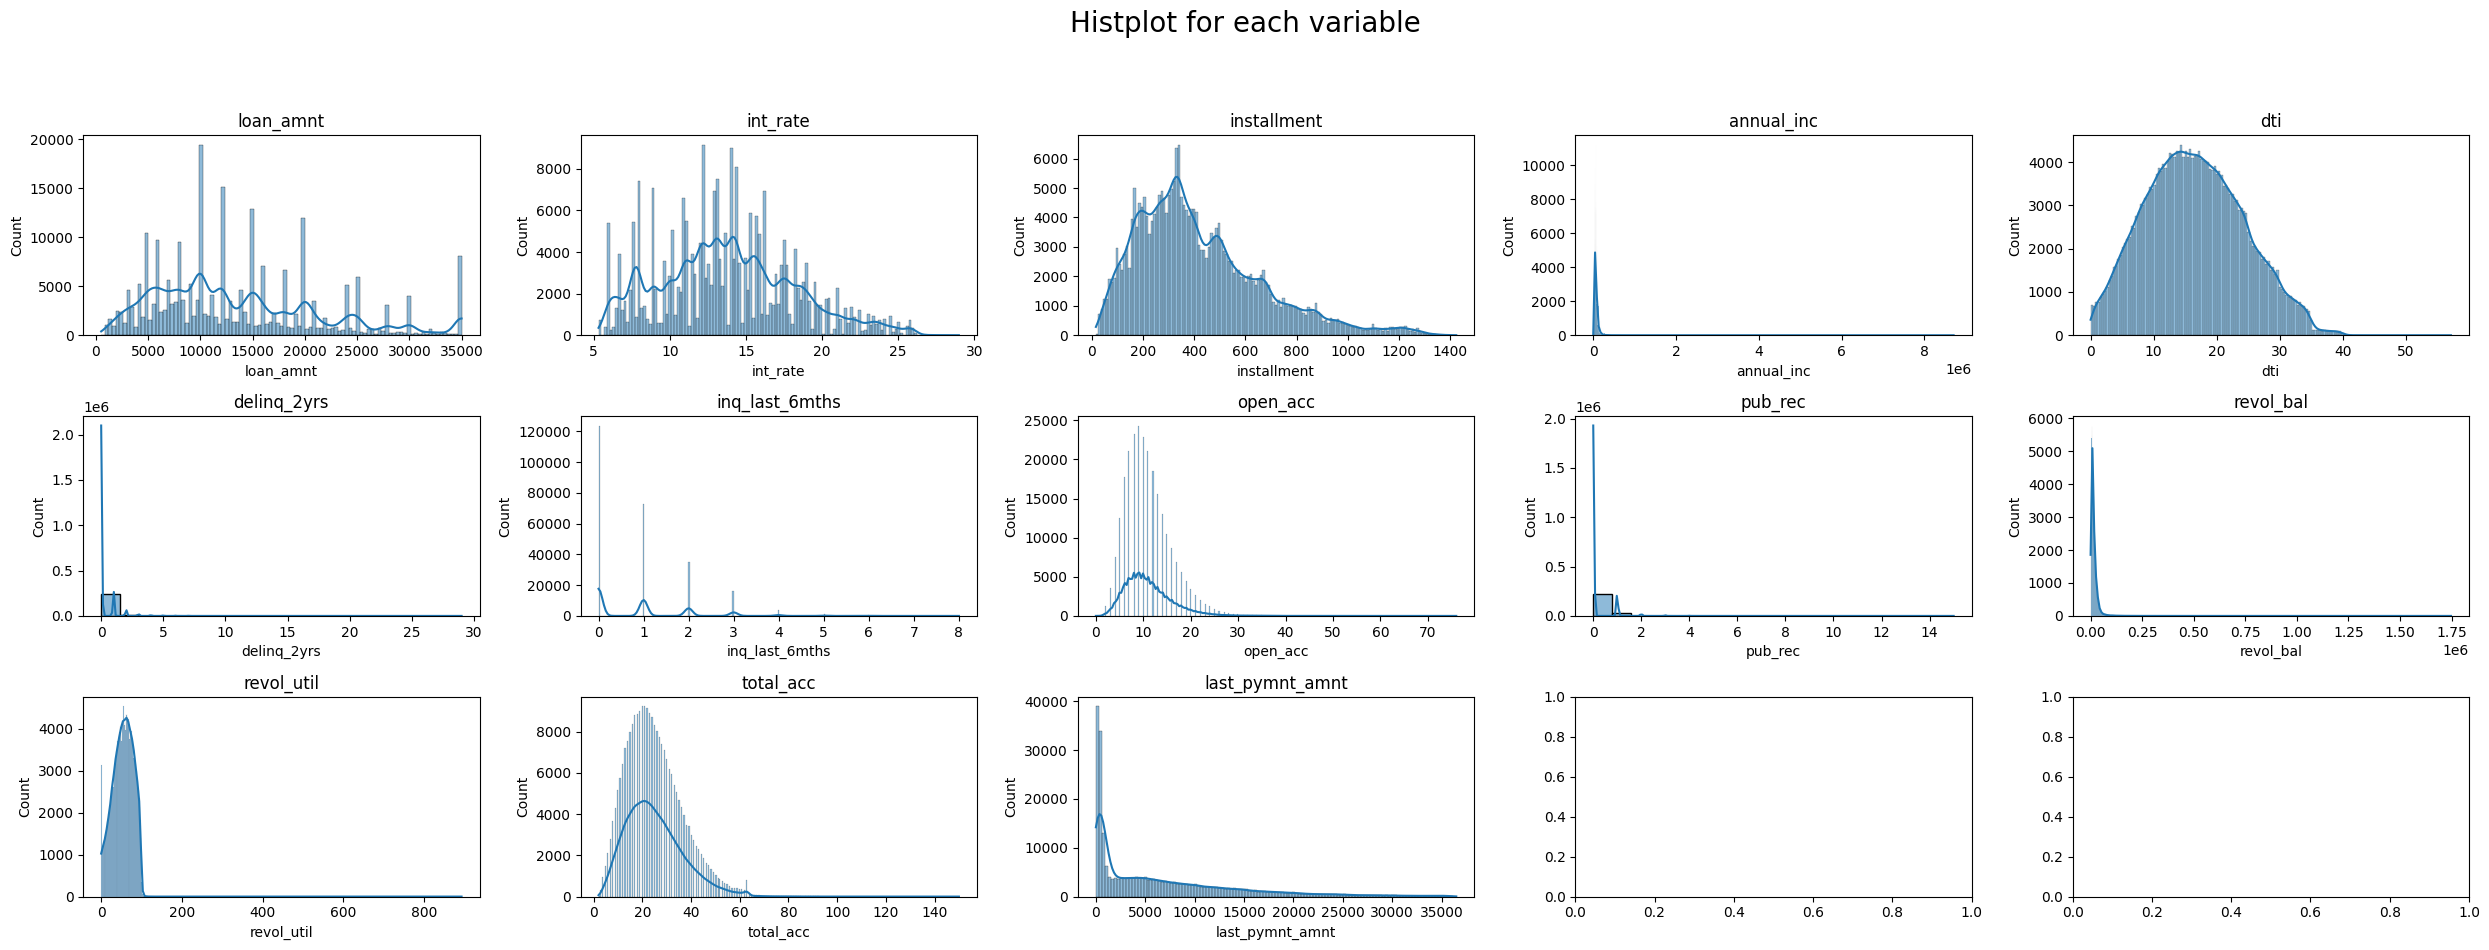

In [30]:
# Creating histograms for numerical features
histplot_visual(data=df, columns=numerical)


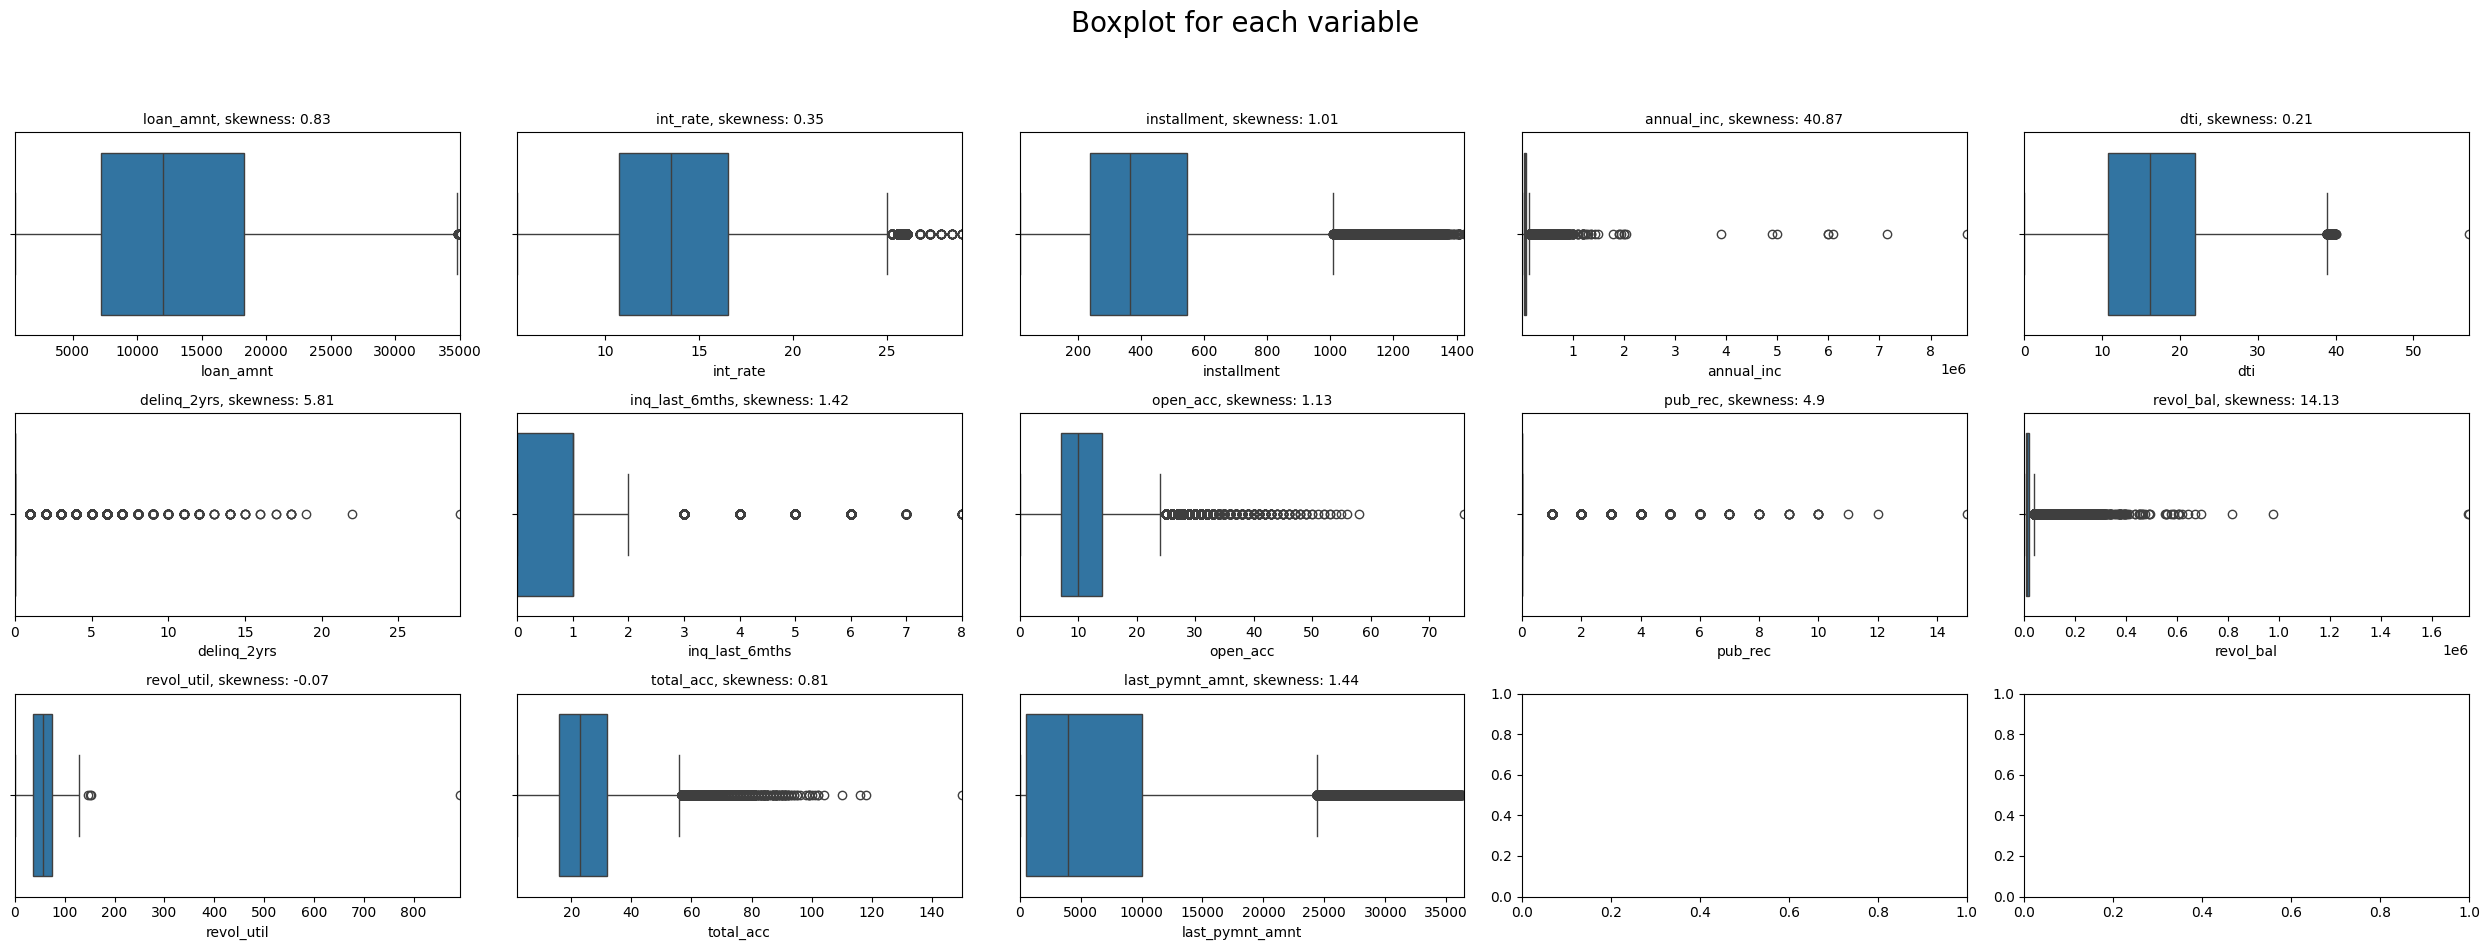

In [31]:
# Creating boxplots for numerical features
boxplots_visual(data=df, columns=numerical)

## Preprocessing

In [32]:
# 1. Preprocessing the 'term' column
# Before preprocessing, let's check the unique values in the 'term' column
print("Before:", df['term'].unique())

Before: [' 36 months' ' 60 months']


In [33]:
# Remove leading/trailing whitespaces and the ' months' suffix
df['term'] = df['term'].map(lambda x: x.strip().rstrip(' months'))

In [34]:
# After preprocessing, let's check the unique values in the 'term' column
print("After:", df['term'].unique())


After: ['36' '60']


In [35]:
# Convert the 'term' column to integers
df['term'] = df['term'].astype('int64')

In [36]:
# 2. Preprocessing the 'emp_length' column
# Before preprocessing, let's check the unique values in the 'emp_length' column
print("Before:", df['emp_length'].unique())

Before: ['10+ years' '< 1 year' '3 years' '9 years' '4 years' '5 years' '1 year'
 '6 years' '2 years' '7 years' '8 years']


In [37]:
# Remove all alphabetic characters and extra spaces
df['emp_length'] = df['emp_length'].str.replace(r'[a-zA-Z]', '')
df['emp_length'] = df['emp_length'].str.replace(' ', '')

In [38]:
# After preprocessing, let's check the unique values in the 'emp_length' column
print("After:", df['emp_length'].unique())

After: ['10+years' '<1year' '3years' '9years' '4years' '5years' '1year' '6years'
 '2years' '7years' '8years']


In [39]:
# Mapping the cleaned 'emp_length' values to integers
df['emp_length'] = df['emp_length'].map({'<1': 0, '1': 1, '2': 2, '3': 3, '4': 4,
                                         '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
                                         '10+': 10})

In [40]:
# 3. Saving the preprocessed dataframe to a pickle file
with open('dataset.pkl', 'wb') as f:
    pickle.dump(df, f)

In [41]:
# 4. Label Encoding for 'grade' and 'sub_grade' columns
# Mapping the 'grade' values to integers
df['grade'] = df['grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

In [42]:
# Mapping the 'sub_grade' values to integers
df['sub_grade'] = df['sub_grade'].map({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4,
                                       'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9,
                                       'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14,
                                       'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19,
                                       'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24,
                                       'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29,
                                       'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34})


In [43]:
# 5. Binary Encoding for 'loan_status' column
# Mapping 'loan_status' values to binary integers (0 for 'Fully Paid' and 1 for 'Charged Off')
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


In [44]:
# 6. One-Hot Encoding for categorical variables
# Converting categorical variables into dummy/indicator variables
df = pd.get_dummies(data=df, columns=['home_ownership', 'verification_status', 'purpose'], drop_first=True)


In [45]:
# Displaying the first few rows of the dataframe to check the preprocessing results
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.0,36,10.65,162.87,1,6,NaN,24000.0,27.65,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2500.0,60,15.27,59.83,2,13,NaN,30000.0,1.00,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2400.0,36,15.96,84.33,2,14,NaN,12252.0,8.72,0.0,...,False,False,False,False,False,False,False,True,False,False
3,10000.0,36,13.49,339.31,2,10,NaN,49200.0,20.00,0.0,...,False,False,False,False,False,True,False,False,False,False
5,5000.0,36,7.90,156.46,0,3,NaN,36000.0,11.20,0.0,...,False,False,False,False,False,False,False,False,False,True



## Model Training

In [46]:
# Step 1: Clean the 'emp_length' column
# Convert 'emp_length' to string type to handle text replacements
df['emp_length'] = df['emp_length'].astype(str)
# Replace specific text values with numbers
df['emp_length'] = df['emp_length'].replace({'10+ years': '10', '< 1 year': '0', 'n/a': '0'})
# Extract numeric part from the string
df['emp_length'] = df['emp_length'].str.extract('(\d+)')
# Replace NaN values with 0
df['emp_length'] = df['emp_length'].fillna(0)
# Convert the column to integer type
df['emp_length'] = df['emp_length'].astype(int)
print("After 'emp_length':", df['emp_length'].unique())



After 'emp_length': [0]


In [47]:
# Step 2: Encode categorical columns
# List of columns that need encoding
categorical_cols = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'purpose']

# Convert each categorical column to numeric using LabelEncoder
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string before encoding



In [48]:
# Step 3: Handle date columns if any (e.g., 'issue_d')
# List of date columns
date_cols = ['issue_d']

# Convert date columns to ordinal numbers (days since 1/1/1970)
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')  # Convert to datetime
        df[col] = df[col].map(pd.Timestamp.toordinal)  # Convert to ordinal


In [49]:
# Step 4: Handle any remaining non-numeric columns
# Convert any remaining object columns to numeric where possible
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill any remaining NaN values with 0
df = df.fillna(0)

# Ensure there are no infinite or excessively large values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [50]:
# Step 5: Divide dataset into independent (X) and dependent (y) features
# X contains all the features except 'loan_status'
# y contains only the 'loan_status' feature which we want to predict
X = df.drop('loan_status', axis=1)
y = df['loan_status']


In [51]:
# Step 6: Split the dataset into training and testing sets
# We use 75% of the data for training and 25% for testing
# random_state=100 ensures reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)


In [52]:

# Step 7: Scale the features using MinMaxScaler
# MinMaxScaler scales each feature to a given range (default is 0 to 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
# Verify that the conversion has been applied correctly
print("Sample rows after cleaning and before scaling:")
print(X.head())

Sample rows after cleaning and before scaling:
   loan_amnt  term  int_rate  installment  grade  sub_grade  emp_length  \
0     5000.0    36     10.65       162.87      1         31           0   
1     2500.0    60     15.27        59.83      2          5           0   
2     2400.0    36     15.96        84.33      2          6           0   
3    10000.0    36     13.49       339.31      2          2           0   
5     5000.0    36      7.90       156.46      0         23           0   

   annual_inc    dti  delinq_2yrs  ...  purpose_home_improvement  \
0     24000.0  27.65          0.0  ...                     False   
1     30000.0   1.00          0.0  ...                     False   
2     12252.0   8.72          0.0  ...                     False   
3     49200.0  20.00          0.0  ...                     False   
5     36000.0  11.20          0.0  ...                     False   

   purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  \
0          False

In [54]:
df['loan_status'].value_counts()

loan_status
0    207723
1     45248
Name: count, dtype: int64

In [55]:
# Print percentage of each loan status
loan_status_counts = df['loan_status'].value_counts()
total = len(df['loan_status'])

# Check if there are enough elements in the series to avoid IndexError
fully_paid_percentage = loan_status_counts.iloc[0] / total * 100 if len(loan_status_counts) > 0 else 0
charged_off_percentage = loan_status_counts.iloc[1] / total * 100 if len(loan_status_counts) > 1 else 0

print("Fully Paid:", fully_paid_percentage)
print("Charged Off:", charged_off_percentage)


Fully Paid: 82.11336477303722
Charged Off: 17.886635226962774


## Handling Imbalanced Dataset

# UnderSampling

In [56]:
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 155708, 1: 34020})
The number of classes after fit Counter({0: 34020, 1: 34020})


In [57]:
model1=RandomForestClassifier()
model1.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [58]:
y_pred=model1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[32814 19201]
 [ 1589  9639]]


Accuracy Score: 
 0.6712679664152554


Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.63      0.76     52015
           1       0.33      0.86      0.48     11228

    accuracy                           0.67     63243
   macro avg       0.64      0.74      0.62     63243
weighted avg       0.84      0.67      0.71     63243



## OverSampling

In [59]:
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X_train_os,y_train_os=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({0: 155708, 1: 34020})
The number of classes after fit Counter({0: 155708, 1: 155708})


In [60]:
model2=RandomForestClassifier()
model2.fit(X_train_os,y_train_os)

RandomForestClassifier()

In [61]:
y_pred=model2.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[48746  3269]
 [ 2313  8915]]


Accuracy Score: 
 0.9117372673655583


Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     52015
           1       0.73      0.79      0.76     11228

    accuracy                           0.91     63243
   macro avg       0.84      0.87      0.85     63243
weighted avg       0.92      0.91      0.91     63243



## SMOTETomek (Both undersampling and oversampling)

In [62]:
smt=SMOTETomek()
X_train_smt,y_train_smt=smt.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_smt)))

The number of classes before fit Counter({0: 155708, 1: 34020})
The number of classes after fit Counter({0: 154987, 1: 154987})


In [ ]:
model3=RandomForestClassifier()
model3.fit(X_train_smt,y_train_smt)

In [ ]:
y_pred=model3.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

#Overall oversampling has the best result so we will go with oversampling

1. Overall Accuracy: The model is correct about 87% of the time when predicting whether a loan will be paid back or not.

2. Precision and F1-Score:
Precision: This measures how many of the loans predicted as “not paid back” (class 1) are actually correct. In our case, it’s relatively low.
F1-Score: It combines precision and recall (ability to find all positive instances) into a single metric. For class 1, it’s also lower than for class 0.

3. Class Imbalance:
The dataset likely has more examples of loans that are paid back (class 0) than those that aren’t (class 1).
This imbalance affects the model’s ability to learn about class 1 accurately.

4. Next Steps:
We should explore ways to address this imbalance, such as oversampling class 1 or adjusting model thresholds.
Further analysis and fine-tuning can help improve predictions for loans that won’t be paid back.

Remember, it’s essential to consider both precision and recall, especially when dealing with imbalanced datasets.

#Hyperparameter Tuning with Keras Tuner

In [ ]:
# Define the build_model function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

Explanation of my 'build_model' function for the Keras Tuner
This function takes in the hyperparameters defined by the tuner and returns a compiled Keras model.
The function defines a Keras Sequential model and adds a variable number of Dense layers (between 2 and 20) with a variable number of units (between 32 and 512).
The output layer has one unit with a sigmoid activation function(Because it's a classification problem).
The function compiles the model using binary crossentropy as the loss function and the Adam optimizer with a learning rate that is randomly chosen from [1e-2, 1e-3, 1e-4].

In [ ]:

tuner = RandomSearch(                   # The tuner uses the build_model function defined earlier as its model-building function,
    build_model,                        # and searches for the best hyperparameters based on validation accuracy.
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2)
tuner.search(X_train_os, y_train_os, epochs=10, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]                # Storing my best hyperparameters in the best_hps variable

Trial 2 Complete [00h 37m 17s]
val_accuracy: 0.8692898750305176

Best val_accuracy So Far: 0.8707603812217712
Total elapsed time: 01h 01m 17s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
12                |19                |num_layers
128               |96                |units_0
96                |416               |units_1
0.0001            |0.001             |learning_rate
384               |32                |units_2
352               |32                |units_3
384               |32                |units_4
384               |32                |units_5
256               |32                |units_6
352               |32                |units_7
352               |32                |units_8
160               |32                |units_9
512               |32                |units_10
416               |32                |units_11
288               |32                |units_12
352               |32                |units_13
352               |32        

# Building our model

In [ ]:
# Define the create_model function to build a Keras model with the optimal hyperparameters
def create_model(num_layers, num_nodes, activation):
    model = keras.Sequential()
    for i in range(num_layers):
        if i==0:                                                           # checks whether the current layer is the first layer of the model.
            model.add(layers.Dense(num_nodes[i], input_dim=X_train.shape[1]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))
        else:
            model.add(layers.Dense(num_nodes[i]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate a list of integers for the number of nodes in each layer
num_nodes = [best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]

model = KerasClassifier(
    build_fn=create_model,
    num_layers=best_hps.get('num_layers'),
    num_nodes=num_nodes,
    activation='relu'
)

Explanation of my 'create_model' function
This function uses the best hyperparameters obtained from the tuner.
This function takes in three arguments- num_layers, num_nodes and activation which are used to build the model with the given number of layers and activation function for each layer.
The model object is created using the keras.Sequential() method.
A loop is run over the layers to add the dense layers to the model.
In the first iteration, a check is performed to see if the current layer is the first layer of the model. If yes, input_dim is added as the input shape for the layer
The num_nodes variable is a list of integers representing the number of nodes in each layer of the model, extracted from the best hyperparameters dictionary.
An activation function and a dropout layer is added after each dense layer. The activation argument is used to specify the activation function for each layer.
The output layer is added with a sigmoid activation function and binary crossentropy loss function. The model is then compiled using the adam optimizer.

# KerasClassifier class from scikit-learn to wrap the create_model function and create a scikit-learn compatible estimator

In [ ]:
# Fit the Keras Classifier model with the optimal hyperparameters
mymodel= model.fit(X_train_os, y_train_os, epochs=20, validation_data=(X_test, y_test))

In [ ]:
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

In [ ]:
# Save the model
# with open('my_model.pkl', 'wb') as file:
#     pickle.dump(model, file)
model.model.save('my_model.h5')

So that's it while the overall accuracy of the model is good at 87%, the precision and f1-score for class 1 (lending loans that are not paid back) are relatively low compared to class 0 (lending loans that are paid back). This means that the model is better at predicting loans that will be paid back than loans that will not be paid back.
This can be due to the imbalancy b/w the classes(0 & 1) in the dataset which may have contributed to this issue, and that further analysis or adjustments to the model may be necessary to improve its performance on predicting class 1.

In [ ]:
# Checkingif the model is working fine or not
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('my_model.h5')

# Use the model to make predictions on X_test
y_pred = model.predict(X_test)

# Print the predicted values
print(y_pred)